In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import glob
import datetime
from joblib import Parallel, delayed
from neuraltda import simpComp as sc
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook

homedir = os.path.expanduser('~')
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = os.path.join(homedir, 'DailyLog/'+daystr+'/')
print(figsavepth)
plt.style.use(os.path.join(homedir, 'code/NeuralTDA/gentnerlab.mplstyle'))

/home/AD/btheilma/DailyLog/20190402/


In [2]:
def get_JS_spec(i, j, speci, specj, specm, beta):
    js = (i, j, sc.sparse_JS_divergence2_spec(speci, specj, specm, beta))
    return js

def compute_JS_div_mtx(lapspectra, Mspectra, beta):
    N = len(lapspectra)
    pairs = [(i, j) for i in range(N) for j in range(i, N)]
    #print('Computing JS Divergences with beta {}...'.format(beta))
    jsmat = np.zeros((N, N))

    jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], Mspectra[(i,j)], beta) for (i, j) in pairs)
    for d in jsdat:
        jsmat[d[0], d[1]] = d[2]
    return jsmat

In [3]:
laplacian_spectra_file = '/home/btheilma/pcsim/Lapspectra.pkl'
m_spectra_file = '/home/btheilma/pcsim/Mspectra.pkl'

with open(laplacian_spectra_file, 'rb') as f:
    lapspectra = pickle.load(f)
with open(m_spectra_file, 'rb') as f:
    mspectra = pickle.load(f)

In [32]:
betas = np.logspace(-2, 2, 10)
jsmats = []
for beta in tqdm(betas):
    jsmats.append(compute_JS_div_mtx(lapspectra, mspectra, beta))

In [33]:
nenvs = 25
ntrials = 10
nreps = 5
nholes = 5

def reduce_jsmat(dsym, nenvs, ntrials, nreps, nholes):
    e1e2means = np.zeros((nenvs, nenvs))
    for env1 in range(nenvs):
        for env2 in range(nenvs):
            env1env2mean = np.mean(dsym[env1*ntrials:(env1*ntrials + ntrials), env2*ntrials:(env2*ntrials + ntrials)])
            e1e2means[env1, env2] = env1env2mean

    hole_mat = np.zeros((nholes, nholes))
    for b1 in range(nholes):
        for b2 in range(nholes):

            m = np.mean(e1e2means[b1*nreps:(b1*nreps+nreps), b2*nreps:(b2*nreps+nreps)])
            hole_mat[b1, b2] = m
    return (e1e2means, hole_mat)

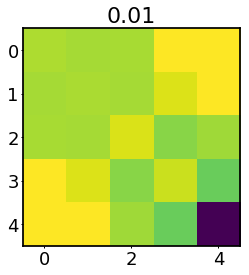

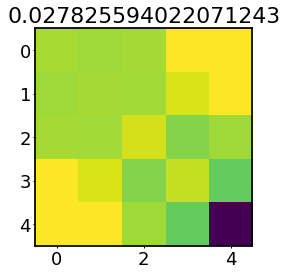

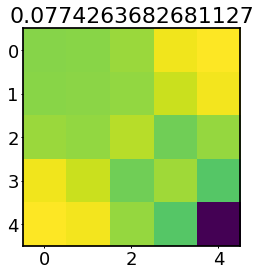

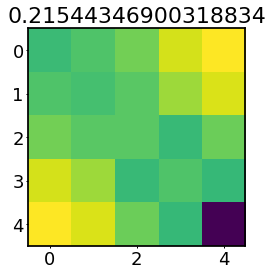

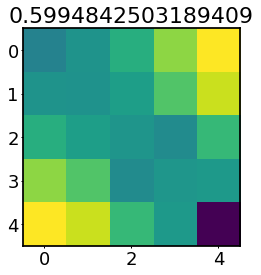

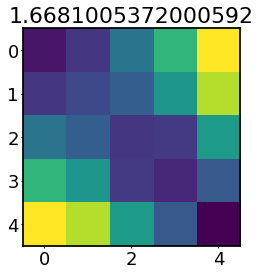

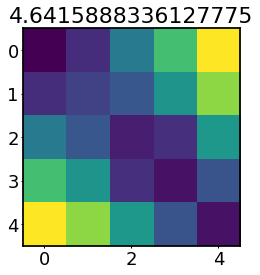

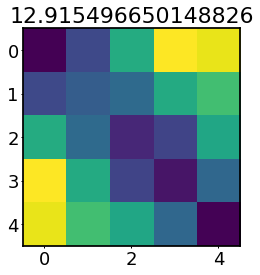

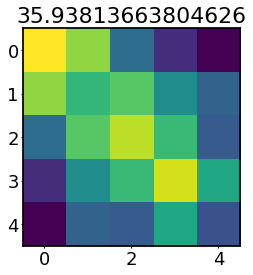

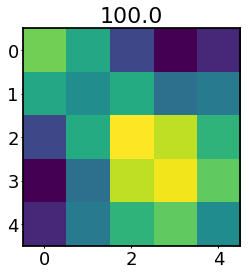

In [34]:
for mat, beta in zip(jsmats, betas):
    plt.figure()
    dsym = mat+mat.T
    a, h = reduce_jsmat(dsym, nenvs, ntrials, nreps, nholes)
    plt.imshow(h)
    plt.title(beta)


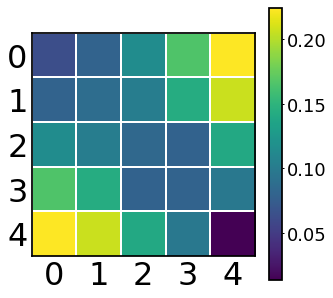

In [35]:
mat = compute_JS_div_mtx(lapspectra, mspectra, 1)
mat = mat+mat.T
a, hole_mat = reduce_jsmat(mat, nenvs, ntrials, nreps, nholes)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.imshow(hole_mat)


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18, )
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family('helvetica')
#cbar.set_label('JS Divergence')

#plt.xlabel('Number of Holes')
#plt.ylabel('Number of Holes')
#plt.title('JS Divergence', size=24)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticklabels(np.arange(6))
ax.set_yticklabels(np.arange(6))
ax.set_xticks(np.arange(-0.5, 4,  1), minor=True);
ax.set_yticks(np.arange(-.5, 4, 1), minor=True);
ax.grid(which='minor', color='white', linewidth=2)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(32)
    item.set_fontname('helvetica')


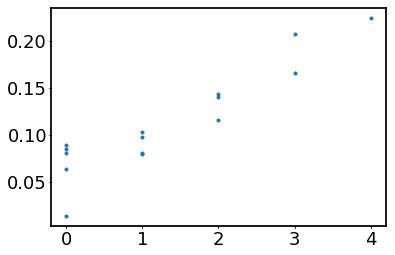

In [36]:
diff = []
js = []
for x in range(nholes):
    for y in range(x, nholes):
        diff.append(np.abs(x-y))
        js.append(hole_mat[x, y])
        
plt.plot(diff, js, '.')

In [12]:
# Compute the ij beta dependendece
ks = list(mspectra.keys())
for x in ks:
    a = int(x[1])
    b = int(x[0])
    mspectra[(a, b)] = mspectra[x]
    
def compute_ij_betasweep(i, j, lapspectra, mspectra, betas):
    res = np.zeros(len(betas))
    N = len(lapspectra)
    pairs = [(x, y) for x in range(50*i, 50*(i+1)) for y in range(50*j, 50*(j+1))]
    for ind, beta in tqdm(enumerate(betas)):
        jsmat = np.zeros((N, N))
        jsdat = Parallel(n_jobs=24)(delayed(get_JS_spec)(i, j, lapspectra[i], lapspectra[j], mspectra[(i,j)], beta) for (i, j) in pairs)
        for d in jsdat:
            jsmat[d[0], d[1]] = d[2]
        res[ind] = np.mean(jsmat)
    return res



In [60]:
betas = np.logspace(-2, 2, 50)
beta00 = compute_ij_betasweep(0, 0, lapspectra, mspectra, betas)
beta40 = compute_ij_betasweep(4,0, lapspectra,mspectra,betas)
beta22 = compute_ij_betasweep(2,2,lapspectra,mspectra,betas)

beta42 = compute_ij_betasweep(4,2, lapspectra,mspectra,betas)

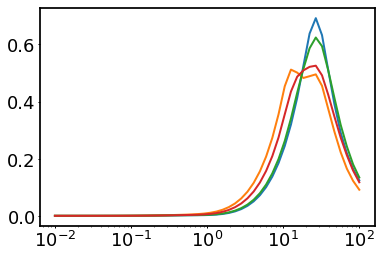

In [61]:
plt.figure()
plt.semilogx(betas, beta00, label='0-0')
plt.semilogx(betas, beta40, label='4-0')
plt.semilogx(betas, beta22, label='2-2')
plt.semilogx(betas, beta42, label='4-2')
plt.legend()

In [64]:
betas = np.logspace(-0.5, 2, 75)
beta00 = compute_ij_betasweep(0, 0, lapspectra, mspectra, betas)
beta40 = compute_ij_betasweep(4,0, lapspectra,mspectra,betas)
beta22 = compute_ij_betasweep(2,2,lapspectra,mspectra,betas)
beta42 = compute_ij_betasweep(4,2, lapspectra,mspectra,betas)

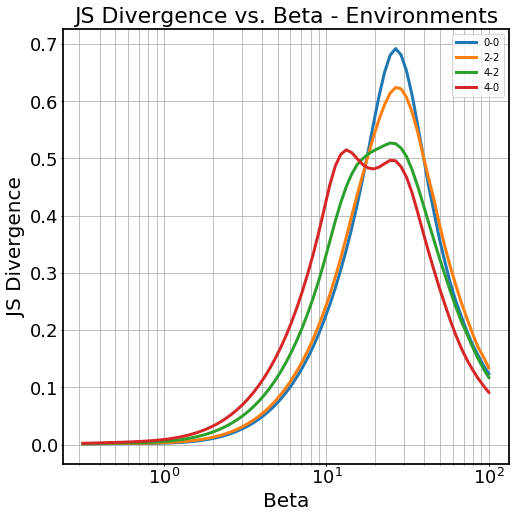

In [84]:
plt.figure(figsize=(8, 8))
plt.semilogx(betas, beta00, label='0-0', linewidth=3, )
plt.semilogx(betas, beta22, label='2-2', linewidth=3, )
plt.semilogx(betas, beta42, label='4-2', linewidth=3, )
plt.semilogx(betas, beta40, label='4-0', linewidth=3, )
plt.legend()
plt.title('JS Divergence vs. Beta - Environments')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.grid(which='both')

In [69]:
x_cross = np.where(np.diff(np.sign(beta40 - beta00)))[0]
a = float(betas[x_cross])


In [13]:
betas = np.logspace(-1, 2, 120)
beta00 = compute_ij_betasweep(0, 0, lapspectra, mspectra, betas)
beta40 = compute_ij_betasweep(4,0, lapspectra,mspectra,betas)
beta22 = compute_ij_betasweep(2,2,lapspectra,mspectra,betas)
beta42 = compute_ij_betasweep(4,2, lapspectra,mspectra,betas)
beta20 = compute_ij_betasweep(2,0, lapspectra,mspectra,betas)
beta44 = compute_ij_betasweep(4,4,lapspectra,mspectra,betas)

In [102]:
# with open('/home/btheilma/envbeta.pkl', 'wb') as f:
#     pickle.dump([beta00, beta40, beta22, beta42, beta20, beta44], f)

In [4]:
with open('/home/btheilma/envbeta.pkl', 'rb') as f:
    [beta00, beta40, beta22, beta42, beta20, beta44] = pickle.load(f)

/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


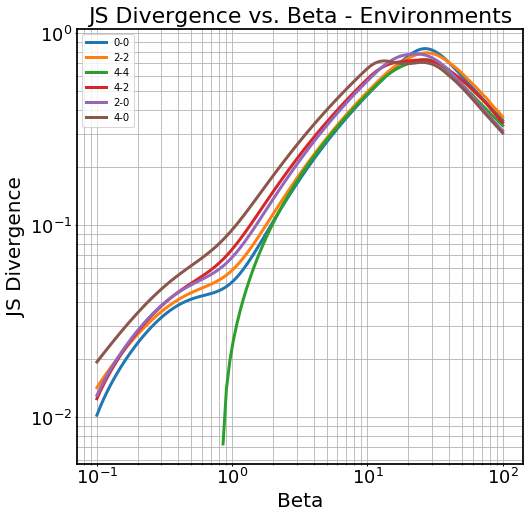

In [14]:
betas = np.logspace(-1, 2, 120)
# import mpld3
# mpld3.enable_notebook()
plt.figure(figsize=(8, 8))
plt.loglog(betas, np.sqrt(beta00), label='0-0', linewidth=3, )
plt.loglog(betas, np.sqrt(beta22), label='2-2', linewidth=3, )
plt.loglog(betas, np.sqrt(beta44), label='4-4', linewidth=3, )
plt.loglog(betas, np.sqrt(beta42), label='4-2', linewidth=3, )
plt.loglog(betas, np.sqrt(beta20), label='2-0', linewidth=3, )
plt.loglog(betas, np.sqrt(beta40), label='4-0', linewidth=3, )
plt.legend()
plt.title('JS Divergence vs. Beta - Environments')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.grid(which='both')
#plt.xlim([1e-1, 1e0])

/home/AD/btheilma/anaconda3/envs/neuraltda-4/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


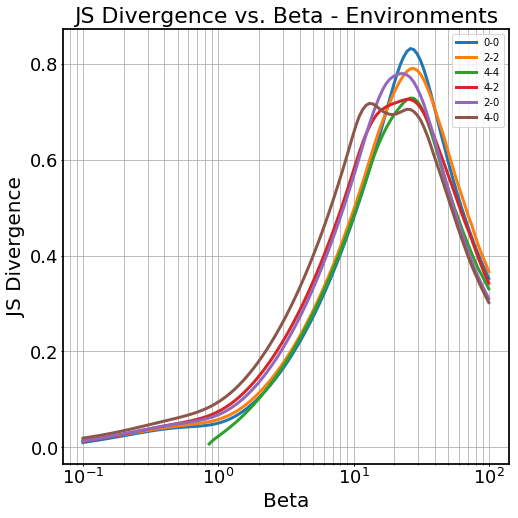

In [15]:
# Square root the JS

betas = np.logspace(-1, 2, 120)
# import mpld3
# mpld3.enable_notebook()
plt.figure(figsize=(8, 8))
plt.semilogx(betas, np.sqrt(beta00), label='0-0', linewidth=3, )
plt.semilogx(betas, np.sqrt(beta22), label='2-2', linewidth=3, )
plt.semilogx(betas, np.sqrt(beta44), label='4-4', linewidth=3, )
plt.semilogx(betas, np.sqrt(beta42), label='4-2', linewidth=3, )
plt.semilogx(betas, np.sqrt(beta20), label='2-0', linewidth=3, )
plt.semilogx(betas, np.sqrt(beta40), label='4-0', linewidth=3, )
plt.legend()
plt.title('JS Divergence vs. Beta - Environments')
plt.xlabel('Beta')
plt.ylabel('JS Divergence')
plt.grid(which='both')
#plt.xlim([1e-1, 1e0])